<h1>PREDICTIVE MAINTANANCE PROJECT</h1>

**GOAL**:
To create an accurate enough machine learning model to predict when a machine is liable to fail and when

First we install and import all the necessary python modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

First we download the datasets from kaggle <a href='https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance/download?datasetVersionNumber=3'>PDM</a> and get our first look at it, then read the files into a dataframe

In [2]:
df_errors = pd.read_csv('PdM_errors.csv')

In [3]:
df_failures = pd.read_csv('PdM_failures.csv')
df_machines = pd.read_csv('PdM_machines.csv')
df_maint = pd.read_csv('PdM_maint.csv')
df_telemetry = pd.read_csv('PdM_telemetry.csv')

In [4]:
df_errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [5]:
df_errors.shape

(3919, 3)

The errors dataset gives us information on the type of error that occurs to which machine and when it happens.

In [6]:
df_machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [7]:
df_machines.shape

(100, 3)

The machines dataset tells us the model and age of all the machines

In [8]:
df_failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [9]:
df_failures.shape

(761, 3)

The failures dataset tells us what daytime a certain machine failed and which component failed

In [10]:
df_maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [11]:
df_maint.shape

(3286, 3)

The maint dataframe tells us when each machine was maintained and for which component

In [12]:
df_telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [13]:
df_telemetry.shape

(876100, 6)

Telemetry dataframe tells us the voltage, rotation speed, pressure and vibration of each machine

<h1>AIM</h1>
<p>1. To explore the data features and gain a preliminary understanding of their </p>
<p>2. To predict when this machine will fail, maybe based on sensor data </p>
Potential questions
3. How many days till failure 
4. Will a machine fail or not?
5. Which component will fail within a week?

<h1> EXPLORATORY DATA ANALYSIS</h1>


<p>Explore each dataset to find or extract or create features that can bear a strong correlation to the failure</p>

Lets check for variable type for each feature in all 4 dataframes

In [14]:
table = [df_errors,df_failures,df_machines,df_maint,df_telemetry]

for df in table:
    print(df.dtypes)

datetime     object
machineID     int64
errorID      object
dtype: object
datetime     object
machineID     int64
failure      object
dtype: object
machineID     int64
model        object
age           int64
dtype: object
datetime     object
machineID     int64
comp         object
dtype: object
datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object


Now we notice that the datatime in all the dataframes is regarded as an object instead of a datetime type so we will have to change that

for df in table:
    df['datetime']=pd.to_datetime(df['datetime'],format='%Y-%m-%d %H:%M:%S')

In [15]:
df_failures['datetime'] = pd.to_datetime(df_failures['datetime'])
df_errors['datetime'] = pd.to_datetime(df_errors['datetime'])
df_maint['datetime'] = pd.to_datetime(df_maint['datetime'])
df_telemetry['datetime'] = pd.to_datetime(df_telemetry['datetime'])

Separate the datetime columns into Years, Months, Days and Hours for each dataframe

<h1>EXPLORING THE FAILURES DATA</h1>

In [16]:
df_failures.dtypes

datetime     datetime64[ns]
machineID             int64
failure              object
dtype: object

In [17]:
df_failures.isnull().sum()

datetime     0
machineID    0
failure      0
dtype: int64

No missing values in the data

In [18]:
df_failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Let's separate the failures dataset(datetime) into its components 

In [19]:
df_failures_time = df_failures
df_failures_time['Year'] = df_failures_time['datetime'].dt.year
df_failures_time['Month'] = df_failures_time['datetime'].dt.month
df_failures_time['Day'] = df_failures_time['datetime'].dt.day
df_failures_time['Hour'] = df_failures_time['datetime'].dt.hour
df_failures_time['Minute'] = df_failures_time['datetime'].dt.minute
df_failures_time['Seconds'] = df_failures_time['datetime'].dt.second
df_failures_time.head()

,datetime,machineID,failure,Year,Month,Day,Hour,Minute,Seconds
0,2015-01-05 06:00:00,1,comp4,2015,1,5,6,0,0
1,2015-03-06 06:00:00,1,comp1,2015,3,6,6,0,0
2,2015-04-20 06:00:00,1,comp2,2015,4,20,6,0,0
3,2015-06-19 06:00:00,1,comp4,2015,6,19,6,0,0
4,2015-09-02 06:00:00,1,comp4,2015,9,2,6,0,0


In [20]:
#Lets check if there are any values in the minute and seconds columns
df_failures_time['Minute'].nunique()

1

In [21]:
df_failures_time['Seconds'].nunique()

1

In [22]:
#So this means we can drop the Minute and Seconds columns from the dataframe
df_failures_time.drop(['Minute','Seconds'],axis=1,inplace=True)
df_failures_time.head()

,datetime,machineID,failure,Year,Month,Day,Hour
0,2015-01-05 06:00:00,1,comp4,2015,1,5,6
1,2015-03-06 06:00:00,1,comp1,2015,3,6,6
2,2015-04-20 06:00:00,1,comp2,2015,4,20,6
3,2015-06-19 06:00:00,1,comp4,2015,6,19,6
4,2015-09-02 06:00:00,1,comp4,2015,9,2,6


In [23]:
#Let's confirm that the year is only in 2015
print(df_failures_time['Year'].max())
print(df_failures_time['Year'].min())

2015
2015


So this entire dataset was within the year of 2015 so we can drop the Year and even the datetime column as well

In [24]:
#df_failures_time.drop(['Year'],axis=1,inplace=True)
df_failures_time.drop(['datetime'],axis=1,inplace=True)

In [25]:
df_failures_time.head()
#Let's group the dataset by various categories and plot the results

,machineID,failure,Year,Month,Day,Hour
0,1,comp4,2015,1,5,6
1,1,comp1,2015,3,6,6
2,1,comp2,2015,4,20,6
3,1,comp4,2015,6,19,6
4,1,comp4,2015,9,2,6


In [26]:
#<h4>Let's group by machineID</h4>
df_failures_time.groupby('machineID')['failure'].count()

machineID
1       7
2       4
3       5
4       6
5       7
       ..
96      5
97      8
98     16
99     19
100     3
Name: failure, Length: 98, dtype: int64

<AxesSubplot:xlabel='machineID'>

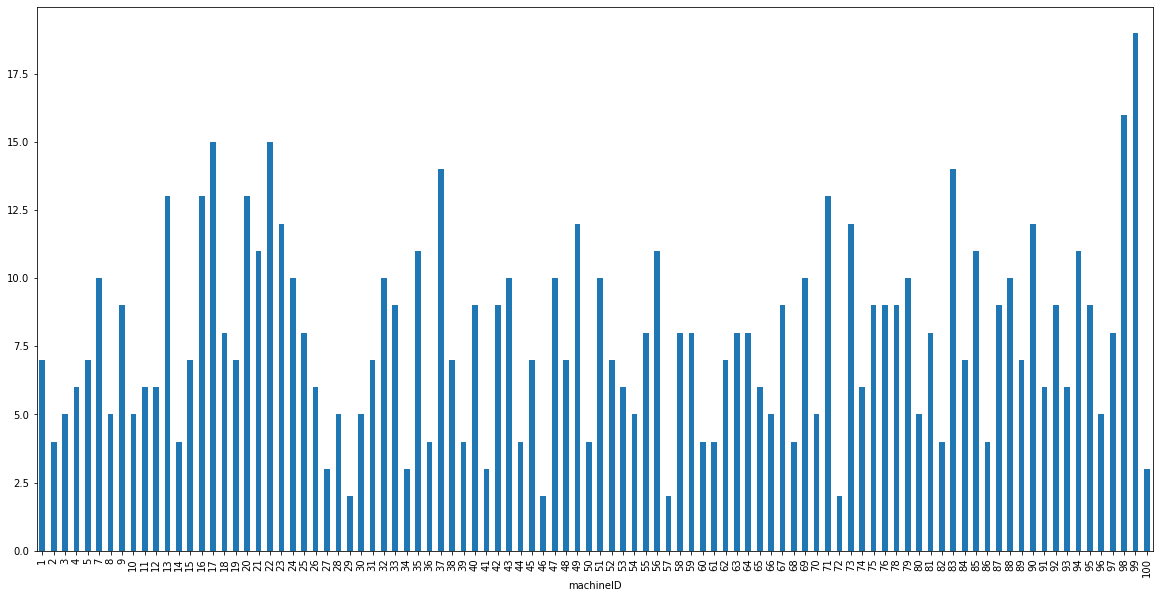

In [27]:
#Let's plot in a bar chart
df_failures_time.groupby('machineID')['failure'].count().plot(kind='bar', figsize = (20,10))

In [28]:
#Let's group by Month and see the number of errors per month
df_failures_time.groupby('Month')['failure'].count()

Month
1     94
2     50
3     59
4     69
5     64
6     58
7     64
8     64
9     59
10    59
11    62
12    59
Name: failure, dtype: int64

<AxesSubplot:xlabel='Month'>

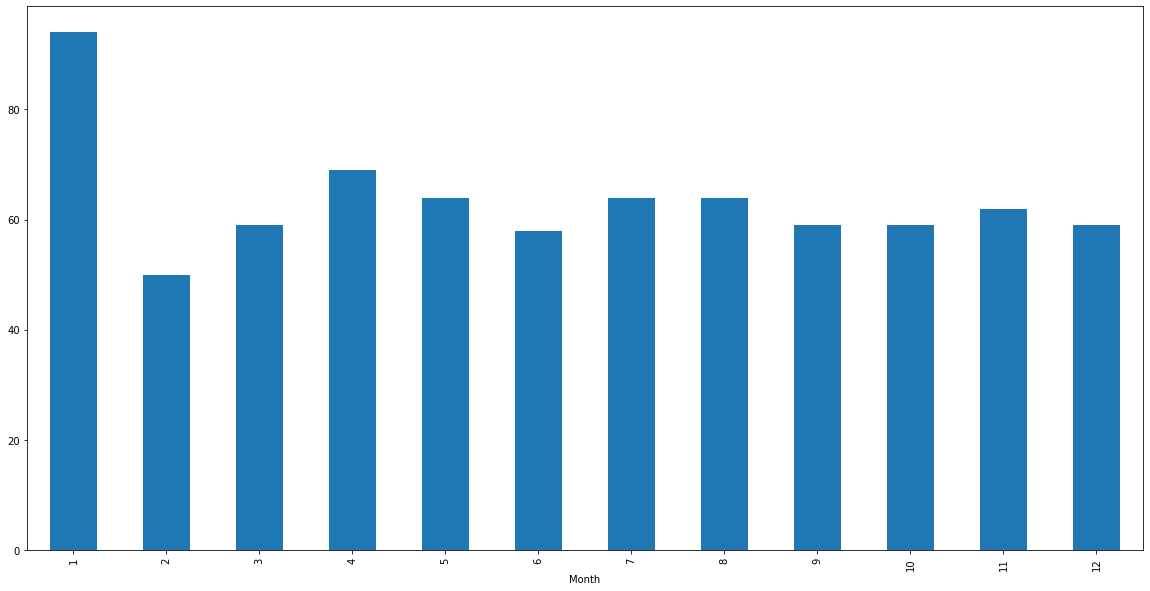

In [29]:
#Let's see this on a bar chart
df_failures_time.groupby('Month')['failure'].count().plot(kind='bar',figsize=(20,10))

January had the most failures while the remaining months seem evenly distributed.

In [30]:
#Let's explore by Day
df_failures_time.groupby('Day')['failure'].count()

Day
1     33
2     53
3     31
4     33
5     28
6     21
7     17
8     12
9     21
10    15
11    11
12    18
13    23
14    22
15    31
16    27
17    41
18    28
19    38
20    36
21    22
22    18
23    17
24    18
25    13
26    11
27    18
28    25
29    25
30    31
31    24
Name: failure, dtype: int64

<AxesSubplot:xlabel='Day'>

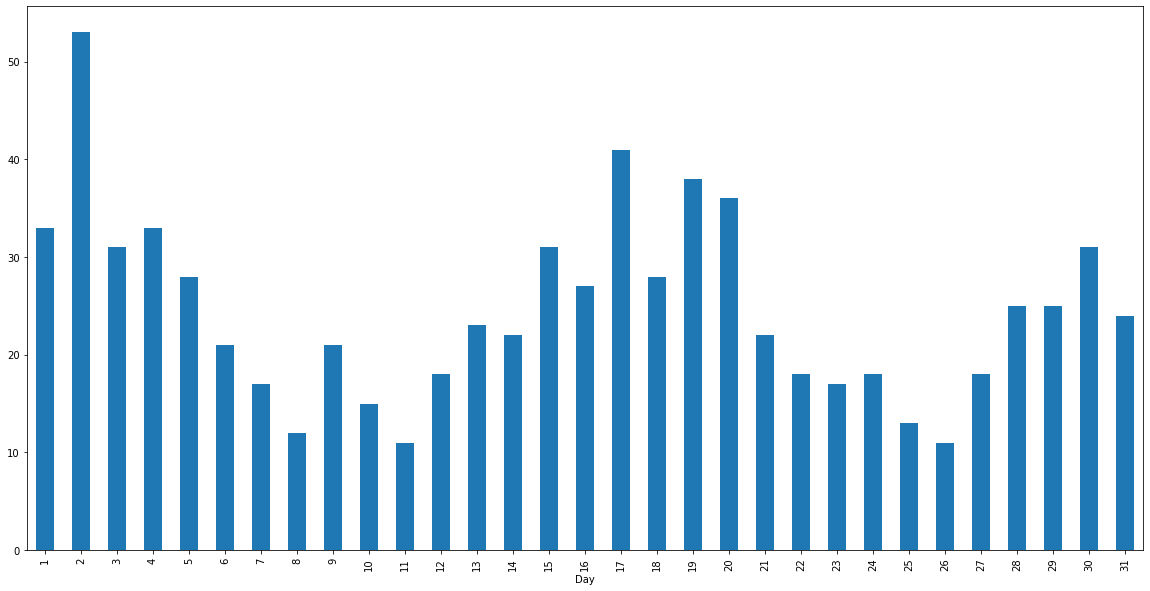

In [31]:
df_failures_time.groupby('Day')['failure'].count().plot(kind='bar',figsize=(20,10))

It appears the most failures happened on the 2nd days of the month

In [32]:
df_failures_time.groupby('Hour')['failure'].count()

Hour
3     18
6    743
Name: failure, dtype: int64

<AxesSubplot:xlabel='Hour'>

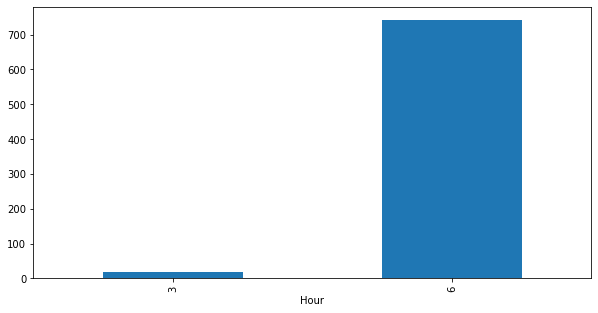

In [33]:
df_failures_time.groupby('Hour')['failure'].count().plot(kind='bar',figsize=(10,5))

Odd, it seems no failures occur except in hours 3 and hours 6. 
Was this due to a scenario where the failures were only reported at certain times in the day?

<AxesSubplot:>

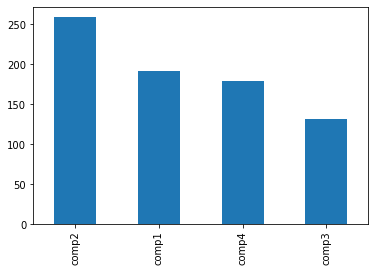

In [48]:
df_failures_time['failure'].value_counts().plot(kind='bar')

Component 2 failed the most out of all the other components.

<h2> Let's explore the ERRORS dataset

In [35]:
df_errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


How many error entries are there?

In [36]:
df_errors.shape

(3919, 3)

Any missing values?

In [37]:
df_errors.isnull().sum()

datetime     0
machineID    0
errorID      0
dtype: int64

No missing values in the error dataframe

Let's check the time-range of the dataset. To do that we have to confirm if the date-time column is of the appropriate type

In [38]:
df_errors['datetime'].describe()

<ipython-input-38-1d55b036d056>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_errors['datetime'].describe()


count                    3919
unique                   2720
top       2015-12-08 06:00:00
freq                       12
first     2015-01-01 06:00:00
last      2016-01-01 05:00:00
Name: datetime, dtype: object

In [39]:
df_errors['datetime'].min()

Timestamp('2015-01-01 06:00:00')

Let us check if there are any duplicates in the data

In [40]:
df_errors.duplicated(keep=False).sum()

0

How many unique timedata entries then?

In [41]:
df_errors['datetime'].nunique()

2720

No, not all of them are unique, which makes sense since errors can occur in multiple machines at the same date and time.
Let us check and see if there's anything special about the times when these errors occur

In [42]:
df_errors['datetime'].value_counts()

2015-12-08 06:00:00    12
2015-01-19 06:00:00    11
2015-04-01 06:00:00    11
2015-09-11 06:00:00    10
2015-03-31 06:00:00    10
                       ..
2015-07-29 13:00:00     1
2015-08-14 10:00:00     1
2015-06-20 13:00:00     1
2015-09-11 05:00:00     1
2015-04-16 13:00:00     1
Name: datetime, Length: 2720, dtype: int64

Every entry at a certain time indicates an error reading from either the same machine or a different one

In [43]:
df_errors['errorID'].value_counts()

error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

<AxesSubplot:>

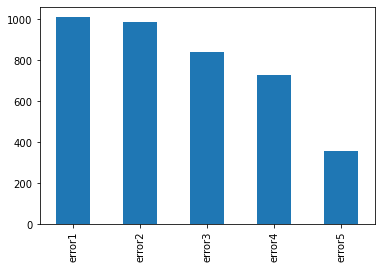

In [49]:
df_errors['errorID'].value_counts().plot(kind='bar')

Which machines show each error the most? Let's start with error1

In [44]:
df_errors[df_errors['errorID']=='error1'].value_counts('machineID')

machineID
90    20
81    19
72    18
10    17
29    16
      ..
2      5
8      4
38     4
39     3
89     2
Length: 100, dtype: int64

<AxesSubplot:>

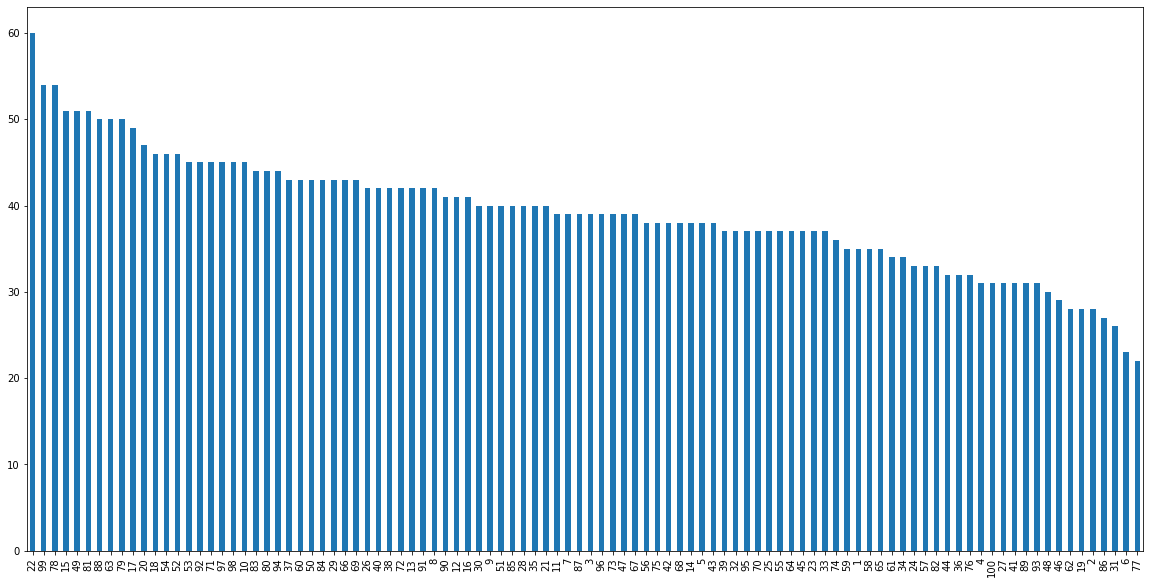

In [51]:
df_errors.machineID.value_counts().plot(kind='bar',figsize=(20,10))

Machine 22 has the most errors of 60 which compared to a total number of 3919 errors isn't significant. The bar chart also indicates that the error readings seem to evenly distributed among all the machines.

In [63]:
df_errors_time = df_errors
#time = ['Year','Month','Day','Hour']

df_errors_time['Year'] = df_errors_time['datetime'].dt.year
df_errors_time['Month'] = df_errors_time['datetime'].dt.month
df_errors_time['Day'] = df_errors_time['datetime'].dt.day
df_errors_time['Hour'] = df_errors_time['datetime'].dt.hour
df_errors_time['Minute'] = df_errors_time['datetime'].dt.minute
df_errors_time['Seconds'] = df_errors_time['datetime'].dt.second
df_errors_time.head()

,datetime,machineID,errorID,Year,Month,Day,Hour,Minute,Seconds
0,2015-01-03 07:00:00,1,error1,2015,1,3,7,0,0
1,2015-01-03 20:00:00,1,error3,2015,1,3,20,0,0
2,2015-01-04 06:00:00,1,error5,2015,1,4,6,0,0
3,2015-01-10 15:00:00,1,error4,2015,1,10,15,0,0
4,2015-01-22 10:00:00,1,error4,2015,1,22,10,0,0


In [64]:
#Let's drop datetime, Minute, Seconds and Year since they don't provide new information
df_errors_time.drop(['datetime','Year','Minute','Seconds'],axis=1,inplace=True)

In [66]:
df_errors_time.head()

,machineID,errorID,Month,Day,Hour
0,1,error1,1,3,7
1,1,error3,1,3,20
2,1,error5,1,4,6
3,1,error4,1,10,15
4,1,error4,1,22,10


<AxesSubplot:>

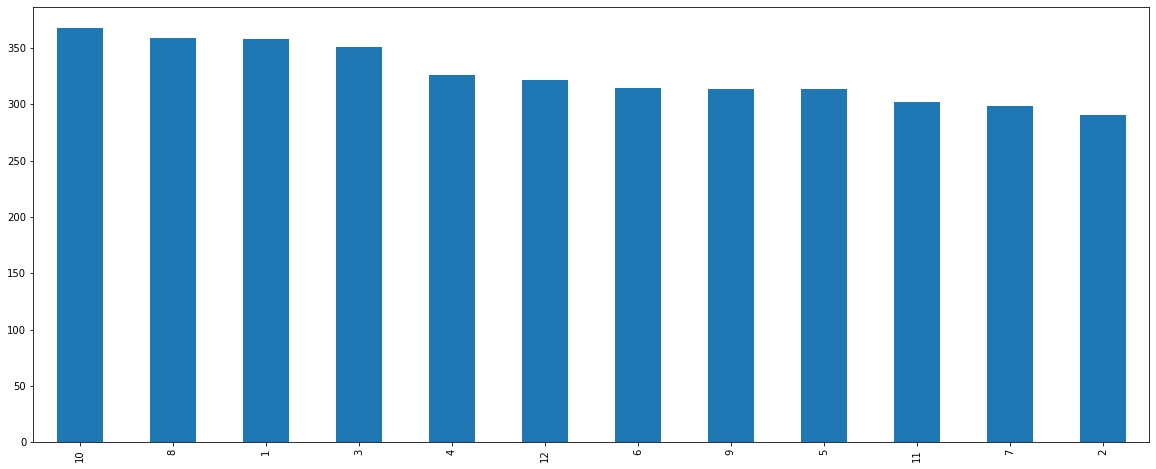

In [69]:
df_errors_time['Month'].value_counts().plot(kind='bar',figsize=(20,8))

The differences in occurence of errors is relatively stable across the months with no dominant outliers

<AxesSubplot:>

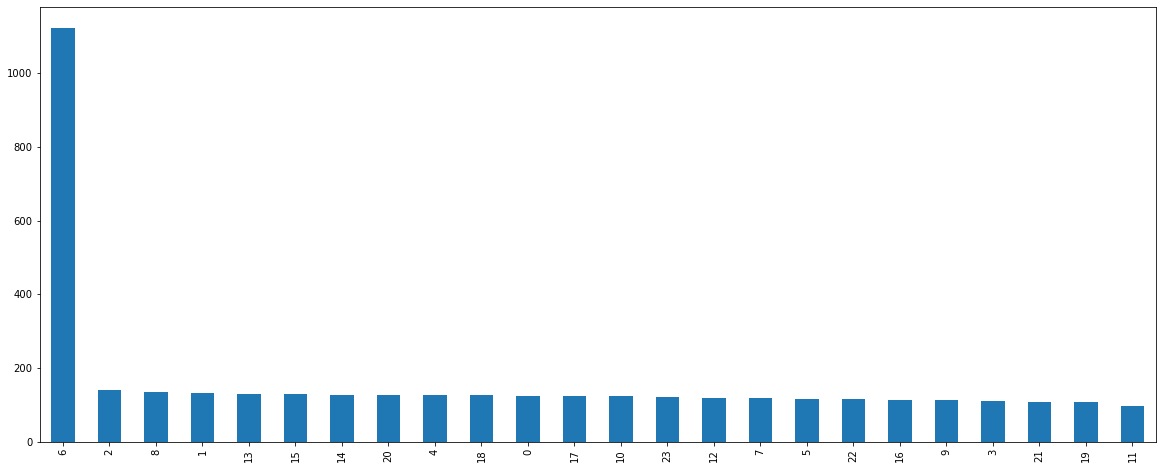

In [70]:
df_errors_time['Hour'].value_counts().plot(kind='bar',figsize=(20,8))

The most numerous errors seemed to occur during the 6th hour 

<AxesSubplot:>

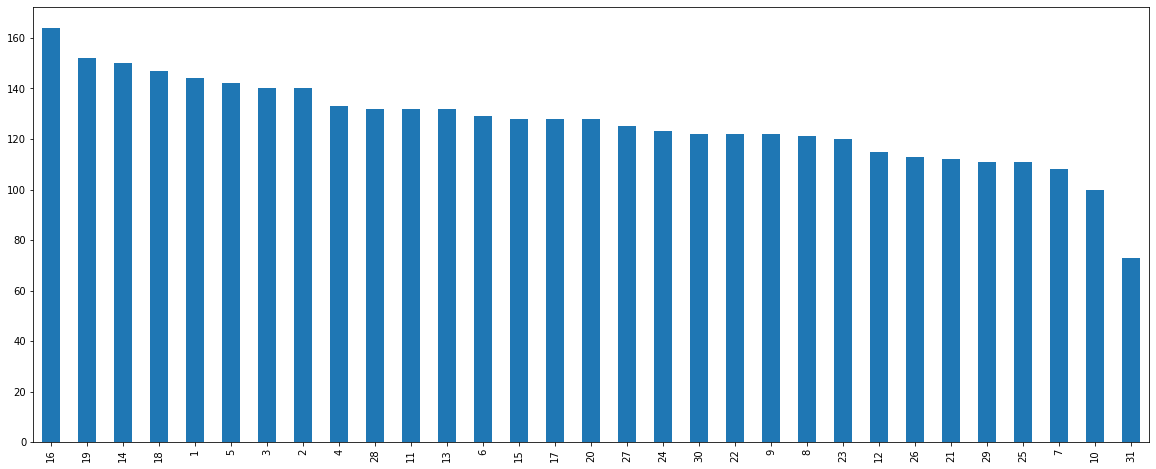

In [71]:
df_errors_time['Day'].value_counts().plot(kind='bar',figsize=(20,8))

<AxesSubplot:>

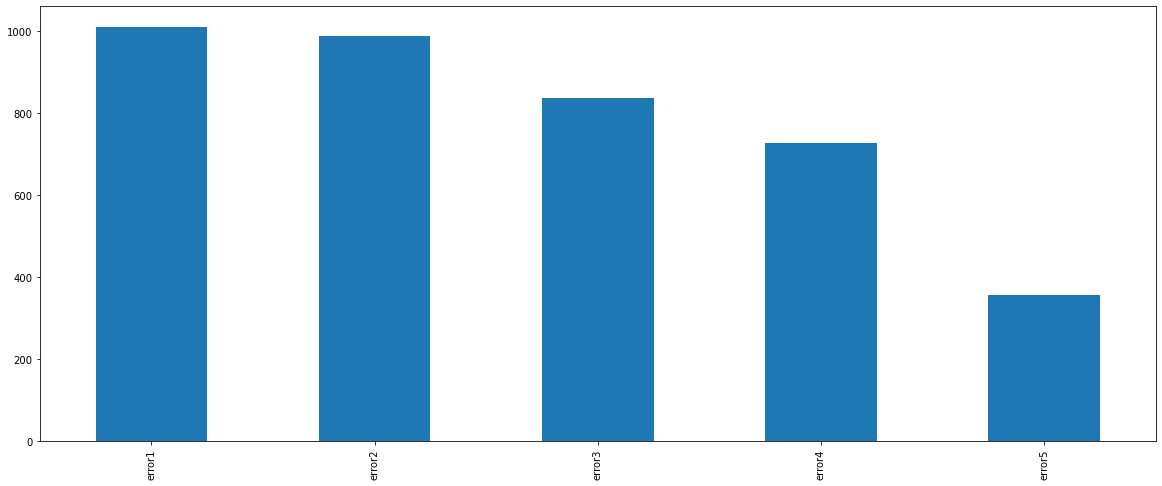

In [72]:
df_errors_time['errorID'].value_counts().plot(kind='bar',figsize=(20,8))

In [75]:
pd.concat([df_errors_time,pd.get_dummies(df_errors_time['errorID'])],axis=1)

,machineID,errorID,Month,Day,Hour,error1,error2,error3,error4,error5
0,1,error1,1,3,7,1,0,0,0,0
1,1,error3,1,3,20,0,0,1,0,0
2,1,error5,1,4,6,0,0,0,0,1
3,1,error4,1,10,15,0,0,0,1,0
4,1,error4,1,22,10,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
3914,100,error2,11,21,8,0,1,0,0,0
3915,100,error1,12,4,2,1,0,0,0,0
3916,100,error2,12,8,6,0,1,0,0,0
3917,100,error3,12,8,6,0,0,1,0,0


Let us drop the datetime column and group the resulting dataset by machineID so we only get columns for machineID and number of errors

In [61]:
ex =df_errors.drop('datetime',axis=1)
ex.head()
ex = ex.groupby(['machineID','errorID'])#['errorID'].value_counts()

In [62]:
ex.head()

,machineID,errorID
0,1,error1
1,1,error3
2,1,error5
3,1,error4
4,1,error4
...,...,...
3903,100,error1
3904,100,error3
3905,100,error3
3907,100,error3


In [53]:
ex[['error1','error2']]

KeyError: "None of [Index(['error1', 'error2'], dtype='object')] are in the [columns]"

In [ ]:
ex['sumoferrors']=ex[['error1','error2','error3','error4','error5']].sum(axis=1)
ex.head()

Let us now look at the failures dataframe and extract the number of failures from it per machine

In [ ]:
df_failures
ex2 = df_failures[['machineID','failure']]
ex2.head()

In [ ]:
ex2=pd.concat([ex2,pd.get_dummies(ex2['failure'])],axis=1)
ex2.head()

ex2.drop('failure',axis=1,inplace=True)
ex2

In [ ]:
ex2 = ex2.groupby('machineID').sum()
ex2

There are only 98 rows indicating that there could have been two machines that did not have any failures during the 1 year the data was collated hence no datapoints. Let's find out which.

In [ ]:
ex2.reset_index(drop=False, inplace=True)


In [ ]:
ex2['comp4']

In [ ]:
list1 = set(ex2['machineID'])
list2 = set(range(1,101))
list2 - list1

Thus we can tell that machines 6 and machines 77 had no failures in the year 2015

In [ ]:
ex2['sumoffailure']=ex2[['comp1','comp2','comp3','comp4']].sum(axis=1)
ex2

In [ ]:
ex.reset_index(drop=False, inplace=True)

In [ ]:
df_error_failures =pd.merge(ex,ex2, on='machineID', how='outer')
df_error_failures

In [ ]:
df_error_failures.corr()

In [ ]:
for i in range(1,101):
    

In [ ]:
df1 = df_errors.groupby('machineID').sum('error1')

In [ ]:
df2 = pd.concat([df_failures, pd.get_dummies(df_failures['failure'])],axis=1).groupby('machineID').sum('comp1')
df2.head()

In [ ]:
set(range(1,101))-set(df_failures['machineID'].unique())

So in the year 2015, machines 6 and machines 77 did not have any failures

In [ ]:
error_model = pd.merge(df1,df2,on=['machineID'],how ='outer')
error_model.fillna(0.0,inplace=True)
error_model

In [ ]:
error_model.head(10)

In [ ]:
error_model.reset_index()

In [ ]:
error_model.describe()

In [ ]:
error_model['failure'] = error_model[['comp1','comp2','comp3','comp4']].sum(axis=1)
error_model.head(10)

In [ ]:
error_model.corr()

<h2>Conclusion from exploring the [df_errors] dataset is this:</h2>
<ol>
    <li> There are no duplicates and no missing values</li>
<li>Errors seem to be evenly distributed among the machines</li>
<li>The data was taken over the course of one year and the time, day or year has no bearing on the occurence or frequency of errors? so we cannot say that errors occurred more in March Or April for any undisclosed reason</li></ol>

<h2>Let us now Explore the FAILURES dataframe

In [ ]:
df_failures.head()

The dataframe shows us which machine failed with [machineID], when it failed with [datetime] and what component needed to be replaced with [failure]

In [ ]:
df_failures.shape

So only 761 failures? Let's check how long the time range is and see if they're any missing values

In [ ]:
df_failures['datetime'].min()

In [ ]:
df_failures['datetime'].max()

The time range is from 2nd January to 31st December, 2015. Thus, It is safe to assume the data was also taken through the 2015 year range.


In [ ]:
df_failures.isnull().sum()

So no missing values, Great!!

How many types of failures are there?

In [ ]:
df_failures['failure'].nunique()

So there are 4 types of components that need to be replaced range from comp1 to comp 4

In [ ]:
df_failures['failure'].describe()

Seems comp2 might be the most frequently replaced component but let's see it in relation to the other components in a histogram

In [ ]:
df_failures['failure'].value_counts().plot(kind='bar')

Nothing too drastic but comp2 still has high number of occurence as compared to the others so we'll keep that in mind.

Which machine has the most number of failures?

In [ ]:
df_failures['machineID'].value_counts()

There's an odd distribution of failures across the 100 machines in this dataframe. Some machines have more than 10 failures in 2015 while others had only 2. One would expect an average number of failures with a not too large deviation. Lets look into it.

In [ ]:
df_failures[df_failures['machineID']==99]

In [ ]:
df_failures[df_failures['machineID']==99]['failure'].value_counts()

In [ ]:
df_maint.head()

In [ ]:
df_maint.shape

In [ ]:
df_maint['comp'].value_counts()

Hmm, component 2 is also the most maintained component here as well. 

In [ ]:
df_maint.isnull().count()

No null values is good

In [ ]:
df_telemetry.head()

In [ ]:
df_telemetry.shape

In [ ]:
df_telemetry.describe()

In [ ]:
df = pd.merge(df_errors, df_failures,on=['datetime','machineID'],how ='inner')
df

There are only 5 instances where an error and a failure occur simultaneously in a machine. This is odd as we were expecting all of the failures or at least most of them to be preceded by an error. This finding requires us to revamp our thought process.

In [ ]:
df1 = pd.merge(df_errors,df_telemetry,on=['datetime','machineID'],how = 'inner')
df1
#df1.shape

In [ ]:
df_errors.shape

In [ ]:
df_failures.shape

Seems that for ever error reading, there was a corresponding telemetry reading which brings up the question of if the other telemetry readings can be dropped or will still be useful. 876,000 entries does seem like a lot considering we only have failure data for 761 incidents.

In [ ]:
df_failures[df_failures['datetime']=='2015-01-05 06:00:00']

In [ ]:
df_errors[df_errors['datetime']=='2015-01-05 06:00:00']

Oh!!! this means that it is rare for a machine to have an error and failure within the same hour which is why merging for the same datetime and machineID yielded such little results

In [ ]:
df2 = pd.merge(df_telemetry,df_failures,on=['datetime','machineID'],how='inner')
df2

lets one hot encode the failure column

In [ ]:
df3 = pd.get_dummies(df2['failure'])
df3.head()

In [ ]:
df4 = pd.concat([df2,df3],axis=1)
df4.head()

In [ ]:
df4.shape

In [ ]:
df4[df4[['datetime','machineID']].duplicated(keep=False)]

Oh!!! This means we can have multiple component failures simultaenously in the same machine at the same datetime hence the duplicate values

In [ ]:
df4.corr()

Hmm, seems comp1 - 4 have some correlation to volt, rotate, pressure and vibration respectively

In [ ]:
df4.corr()['comp1']

In [ ]:
df5 = pd.merge(df_maint,df4,on=['datetime','machineID'],how='inner')
df5

Let's rename 

In [ ]:
df_maint[['datetime','machineID']].duplicated(keep=False).value_counts()

In [ ]:
df_maint[df_maint[['datetime','machineID']].duplicated(keep=False)]

Let's rename 'comp' from df_maint to 'maint' so we can differentiate between failure and maintenance components

In [ ]:
df_maint['maint']=df_maint.comp.str.replace('comp','maint')
df_maint.drop('comp',axis=1)

In [ ]:
df_maint2=pd.concat([df_maint,pd.get_dummies(df_maint['maint'])],axis=1)
df_maint2.drop('maint',axis=1)
df_maint2

In [ ]:
df_maint2.drop(['maint','comp'],axis=1,inplace=True)

In [ ]:
df_err_fail = pd.merge(df4,df_maint2,on=['datetime','machineID'],how='inner')

In [ ]:
df_err_fail

In [ ]:
#df_err_fail.corr()

Let's also merge the errors dataframe as well so we can create a merged dataframe of errors, failures and maintanance

In [ ]:
a = pd.get_dummies(df_errors['errorID'])
df_errors = pd.concat([df_errors,a],axis=1)
df_errors

In [ ]:
df_err_fail_maint = pd.merge(df_err_fail,df_errors,on=['machineID'],how='inner')
df_err_fail_maint

In [ ]:
df_err_fail_maint[['comp1','comp2','comp3','comp4','maint1','maint2','maint3','maint4','error1','error2','error3','error4','error5']].corr()

#df = pd.merge(df_err_fail,df_errors,on=['datetime','machineID'],how='inner')
#df

In [ ]:
df_machines


df2 is the dataframe of failures. Failures occur when a machine breaks down and has to have parts/components replaced

In [ ]:
df1.isnull().count()

The PdM_errors dataframe contains a unique machineID and the type of error that occurs and when this errors occur


In [ ]:
df2.head()

In [ ]:
df3.head()

Let us merge the datasets df1 to df5

In [ ]:
df1.set_index(['machineID'],inplace=True)

In [ ]:
df1.head()

In [ ]:
df2.set_index(['machineID'],inplace=True)
df3.set_index(['machineID'],inplace=True)
df4.set_index(['machineID'],inplace=True)
df5.set_index(['machineID'],inplace=True)

In [ ]:
df5.head()

In [ ]:
df4.head()

In [ ]:
df=pd.concat([df1,df2])
df.head()